In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Source directory of the dataset (contains all classes)
source_dir = "/kaggle/input/bangla-lekha-isolated-dataset/BanglaLekha-Isolated/Images"

# Output base directory for splits
output_base = "/kaggle/working/banglalekha_compound_split"

# List compound letter folder names manually here (or generate dynamically if you want)
# For example, suppose compound letters start from folder index 60 onwards (adjust as needed)
all_folders = sorted(os.listdir(source_dir))
compound_folders = all_folders[60:]  # adjust index range if needed

# Create output folders
splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

for folder_name in compound_folders:
    class_path = os.path.join(source_dir, folder_name)
    if not os.path.isdir(class_path):
        continue

    # List all image files in the folder
    all_imgs = [f for f in os.listdir(class_path) if f.endswith(".png") or f.endswith(".jpg")]
    if len(all_imgs) == 0:
        print(f"No images found in {class_path}, skipping.")
        continue

    # Split: 70% train, 15% val, 15% test
    train_imgs, temp_imgs = train_test_split(all_imgs, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Copy images into respective folders named by original folder_name
    for split, split_imgs in zip(splits, [train_imgs, val_imgs, test_imgs]):
        out_dir = os.path.join(output_base, split, folder_name)
        os.makedirs(out_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(out_dir, img))

print("✅ Compound letters split completed with original folder labels.")


✅ Compound letters split completed with original folder labels.


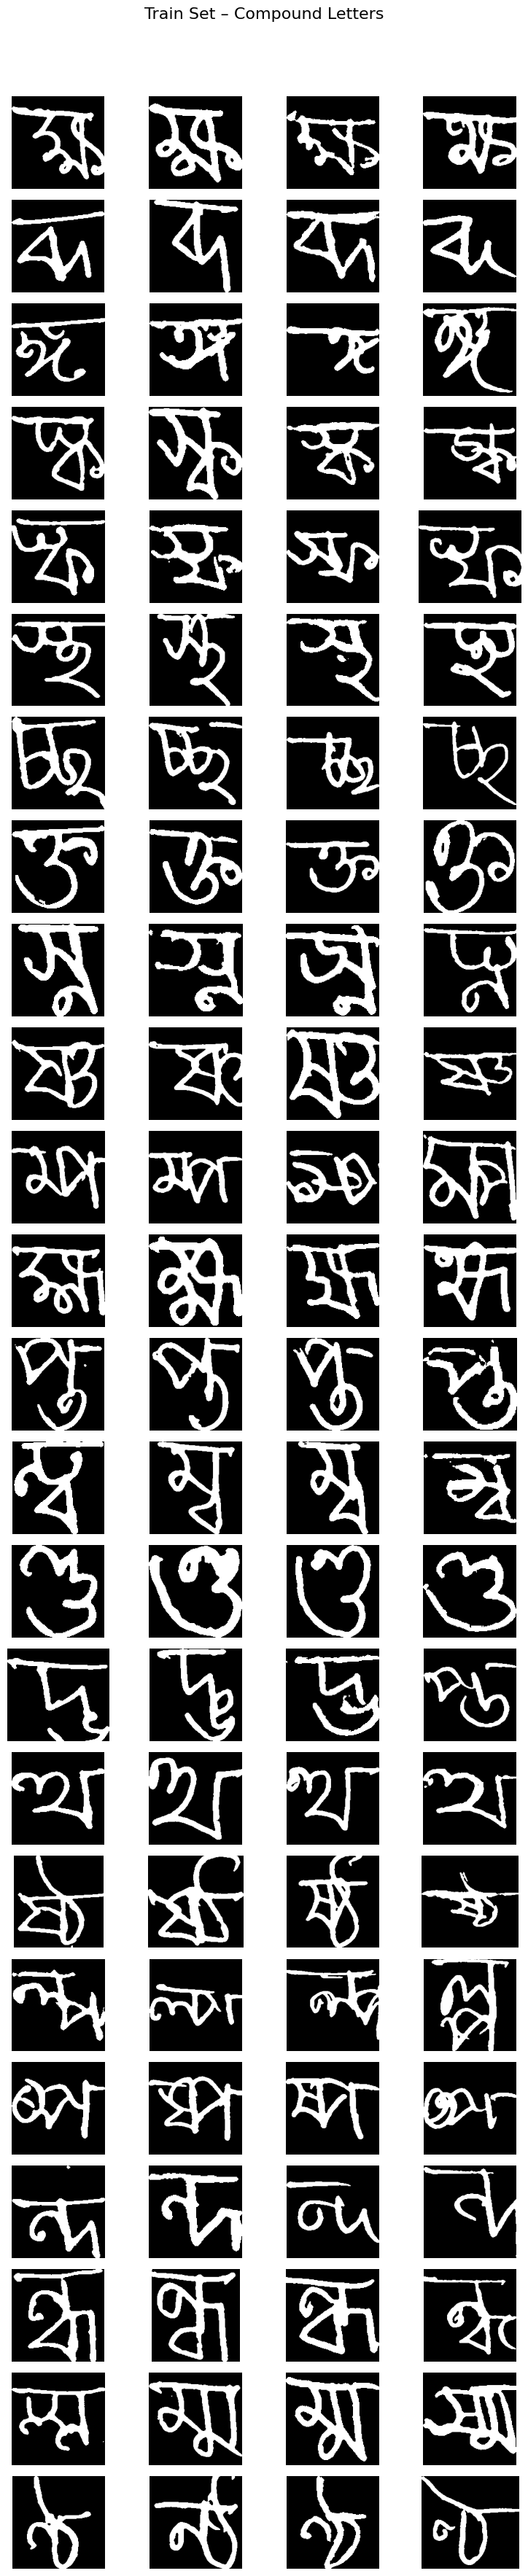

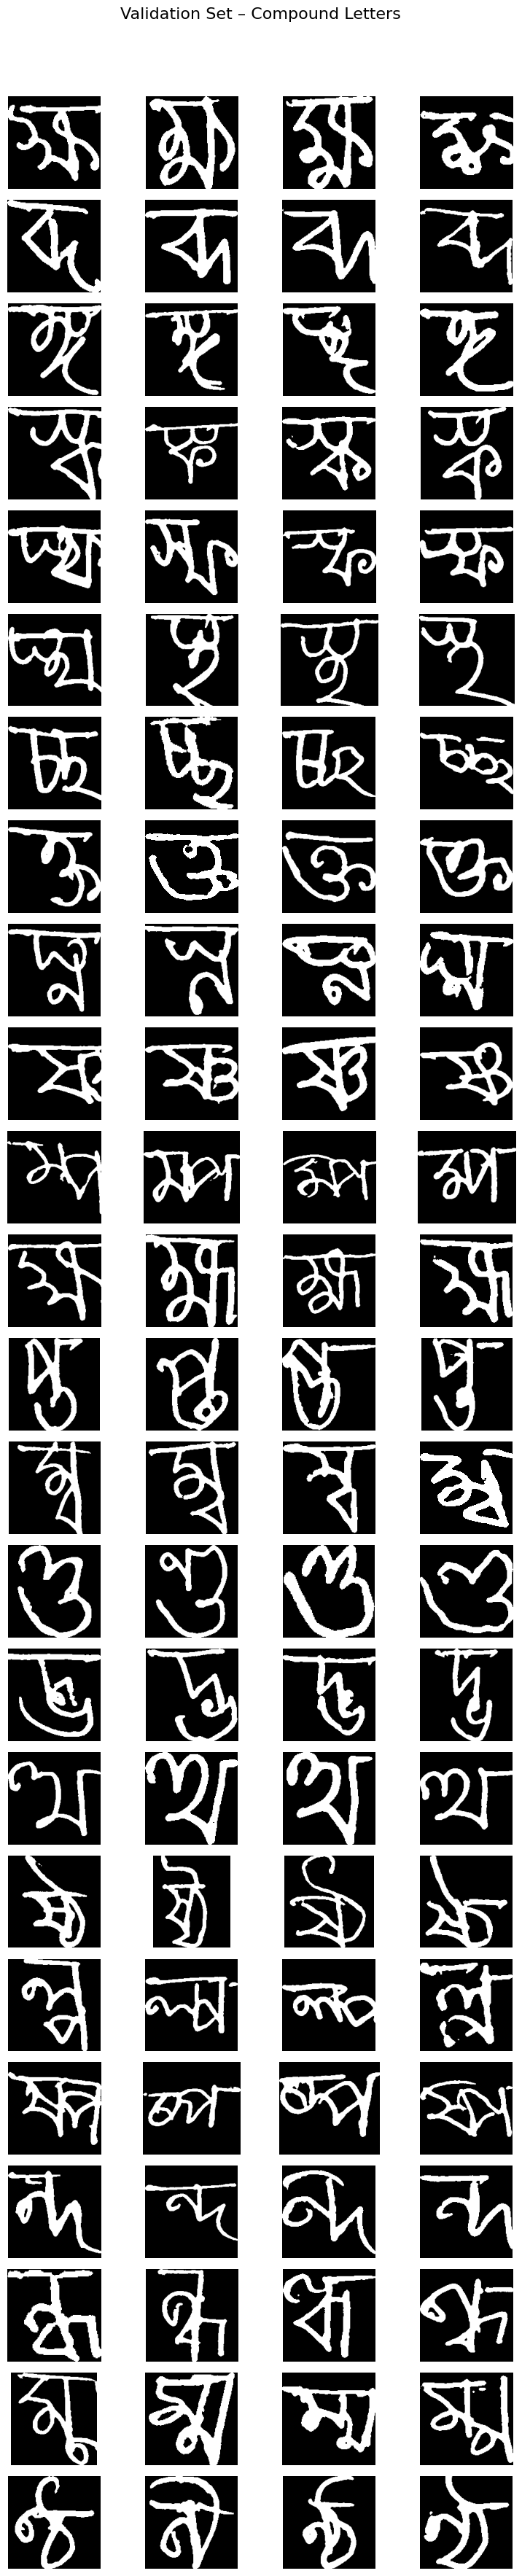

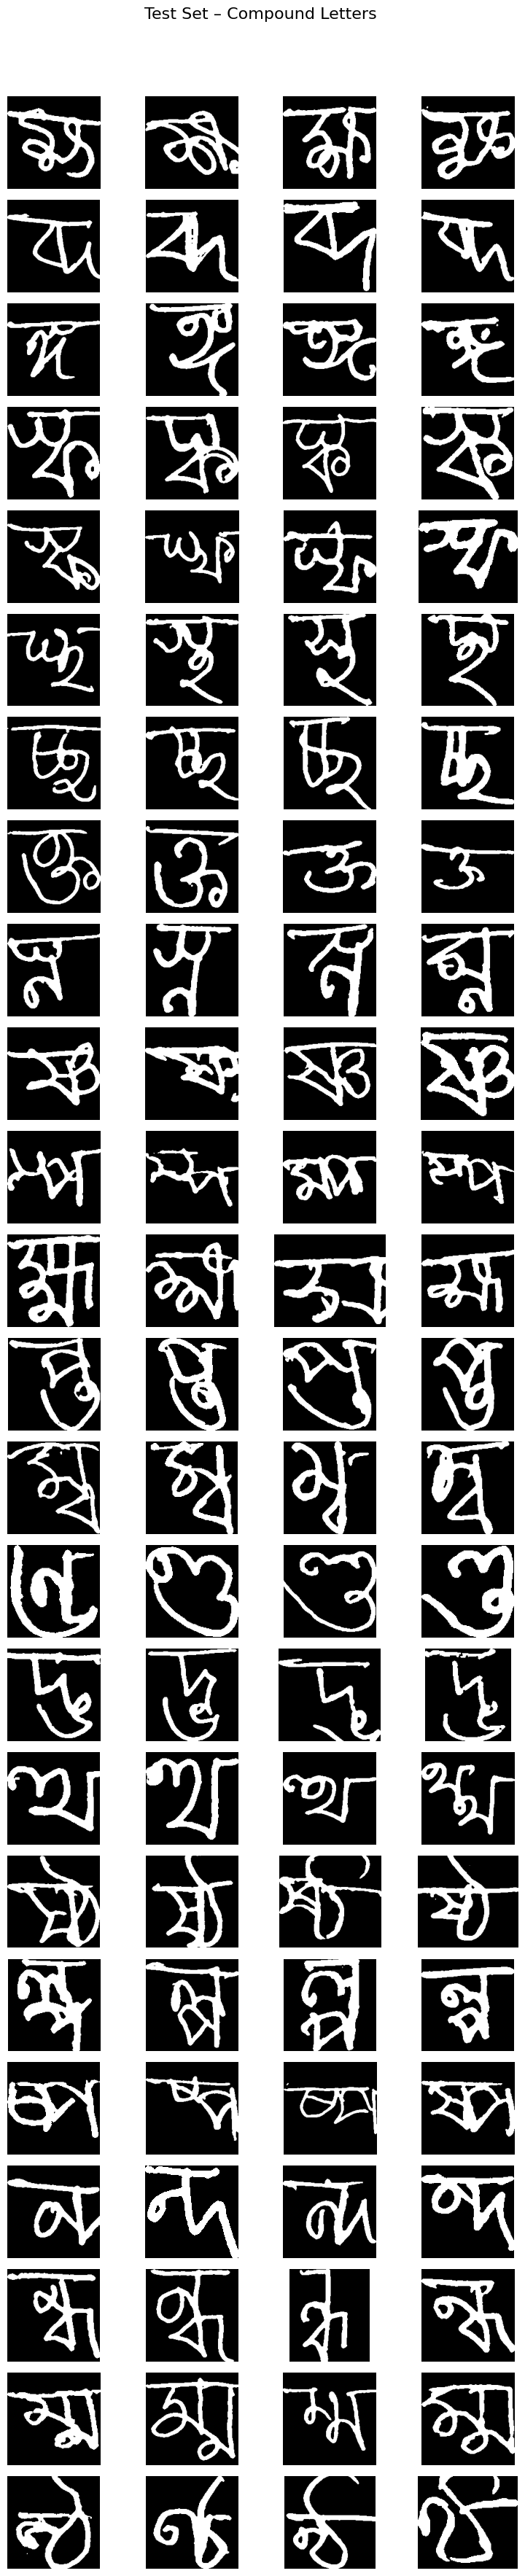

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_compound_letters(base_dir, title, num_classes=24, samples_per_class=4):
    """
    Visualize sample images from compound letter folders.

    Args:
        base_dir (str): Path to the dataset split (train/val/test).
        title (str): Title of the figure.
        num_classes (int): Number of compound classes (default = 24).
        samples_per_class (int): Number of images to display per class.
    """
    class_dirs = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])[:num_classes]
    
    plt.figure(figsize=(samples_per_class * 2, num_classes * 1.5))
    plt.suptitle(title, fontsize=16)

    img_count = 1
    for class_idx, class_name in enumerate(class_dirs):
        class_path = os.path.join(base_dir, class_name)
        img_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg'))])[:samples_per_class]
        
        for sample_idx, img_file in enumerate(img_files):
            img = mpimg.imread(os.path.join(class_path, img_file))
            plt.subplot(num_classes, samples_per_class, img_count)
            plt.imshow(img, cmap='gray')
            plt.axis("off")
            if sample_idx == 0:
                plt.ylabel(class_name, fontsize=9)
            img_count += 1

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

output_base = "/kaggle/working/banglalekha_compound_split"

visualize_compound_letters(os.path.join(output_base, 'train'), "Train Set – Compound Letters")
visualize_compound_letters(os.path.join(output_base, 'val'), "Validation Set – Compound Letters")
visualize_compound_letters(os.path.join(output_base, 'test'), "Test Set – Compound Letters")


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 60
num_classes = 24  # Update if using fewer classes


# Paths after splitting
train_path = "/kaggle/working/banglalekha_compound_split/train"
val_path   = "/kaggle/working/banglalekha_compound_split/val"
test_path  = "/kaggle/working/banglalekha_compound_split/test"

# Augmented training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


2025-06-12 01:14:41.224775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749690881.498785      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749690881.576607      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 33174 images belonging to 24 classes.
Found 7113 images belonging to 24 classes.
Found 7120 images belonging to 24 classes.


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(32, 32, 1), num_classes=24):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)  # Slightly increased dropout

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)  # Extra convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(1024)(x)  # Increased size
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhanced')
    return model

print("Model is initialized!")

Model is initialized!


In [7]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749690934.469892      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749690934.470598      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNetEnhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,371,864 (20.49 MB)

 Trainable params: 5,368,024 (20.48 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [9]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=12, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_Bangla10Classes_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=60

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749690972.768685     128 service.cc:148] XLA service 0x7b4ccc002ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749690972.769978     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749690972.770002     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749690973.570477     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/519 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.0430 - loss: 3.8417 

I0000 00:00:1749690982.007136     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


518/519 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4510 - loss: 1.9805
Epoch 1: val_accuracy improved from -inf to 0.73541, saving model to scriptnet_Bangla10Classes_best.h5
519/519 ━━━━━━━━━━━━━━━━━━━━ 56s 76ms/step - accuracy: 0.4517 - loss: 1.9779 - val_accuracy: 0.7354 - val_loss: 0.9219 - learning_rate: 0.0010
Epoch 2/60
518/519 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8041 - loss: 0.6345
Epoch 2: val_accuracy improved from 0.73541 to 0.87263, saving model to scriptnet_Bangla10Classes_best.h5
519/519 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.8041 - loss: 0.6344 - val_accuracy: 0.8726 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 3/60
518/519 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8486 - loss: 0.4834
Epoch 3: val_accuracy improved from 0.87263 to 0.88612, saving model to scriptnet_Bangla10Classes_best.h5
519/519 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.8486 - loss: 0.4834 - val_accuracy: 0.8861 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 

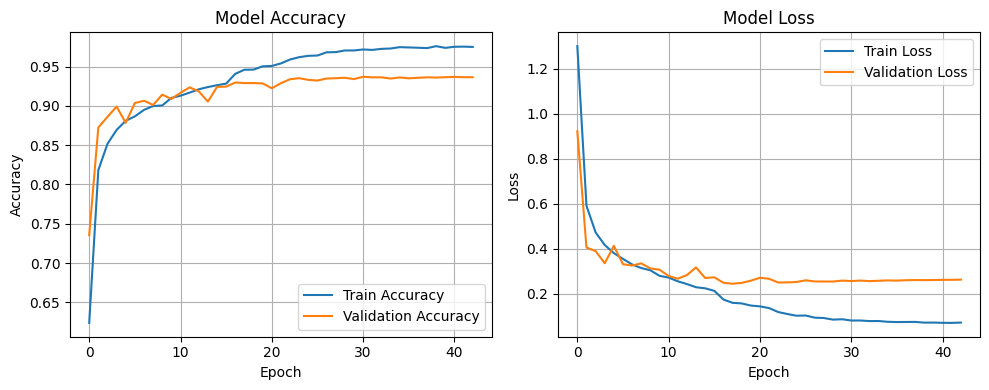

In [10]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


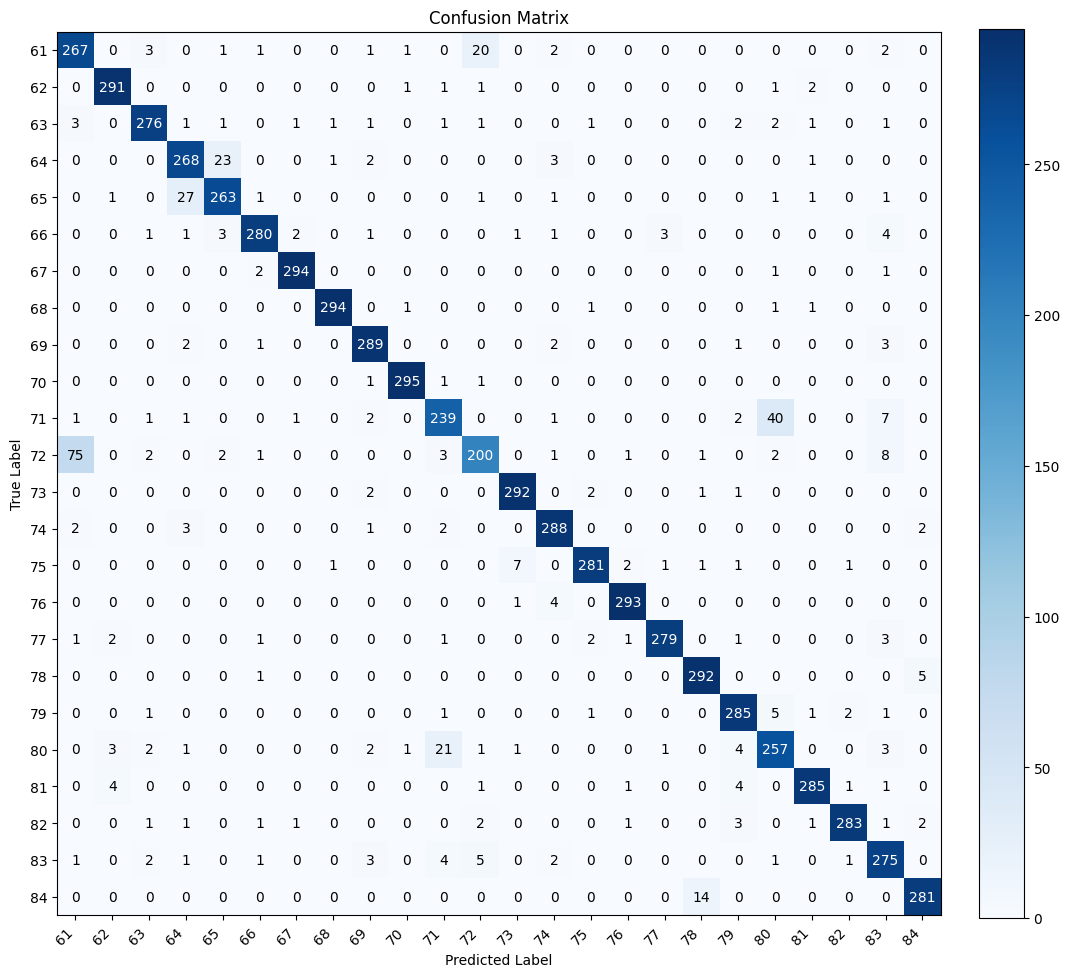

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_general(y_true, y_pred, class_labels, title="Confusion Matrix"):
    num_classes = len(class_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Dynamic figure size based on number of classes
    cell_scale = 0.45  # You can tune this for spacing
    fig_width = min(25, max(8, num_classes * cell_scale))
    fig_height = min(25, max(6, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Display matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Colorbar height matches matrix height
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)

    # Set axis labels and ticks
    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    # Adjust tick labels: auto font size and rotation
    tick_font = max(6, 12 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    # Annotate cells with counts
    fmt = 'd'
    thresh = cm.max() / 2.
    annotation_font = max(5, 12 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Example usage (in your notebook):
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix_general(y_true, y_pred, class_labels)


In [12]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
📋 Classification Report:

              precision    recall  f1-score   support

          61     0.7629    0.8960    0.8241       298
          62     0.9668    0.9798    0.9732       297
          63     0.9550    0.9420    0.9485       293
          64     0.8758    0.8993    0.8874       298
          65     0.8976    0.8855    0.8915       297
          66     0.9655    0.9428    0.9540       297
          67     0.9833    0.9866    0.9849       298
          68     0.9899    0.9866    0.9882       298
          69     0.9475    0.9698    0.9585       298
          70     0.9866    0.9899    0.9883       298
          71     0.8723    0.8102    0.8401       295
          72     0.8584    0.6757    0.7561       296
          73     0.9669    0.9799    0.9733       298
          74     0.9443    0.9664    0.9552       298
          75     0.9757    0.9525    0.9640       295
          76     0.9799    0.9832    0.9816       298
          77 

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(24)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |     298 |       0.8960 |             267.0000 |       0.9878 |             294.3744
    1 |     297 |       0.9798 |             291.0000 |       0.9985 |             296.5647
    2 |     293 |       0.9420 |             276.0000 |       0.9981 |             292.4421
    3 |     298 |       0.8993 |             268.0000 |       0.9944 |             296.3401
    4 |     297 |       0.8855 |             263.0000 |       0.9956 |             295.6941
    5 |     297 |       0.9428 |             280.0000 |       0.9985 |             296.5647
    6 |     298 |       0.9866 |             294.0000 |       0.9993 |             297.7816
    7 |     298 |       0.9866 |             294.0000 |       0.9996 |             297.8690
    8 |     298 |       0.9698 |       

112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step

📋 Classification Report:

              precision    recall  f1-score   support

          61     0.7629    0.8960    0.8241       298
          62     0.9668    0.9798    0.9732       297
          63     0.9550    0.9420    0.9485       293
          64     0.8758    0.8993    0.8874       298
          65     0.8976    0.8855    0.8915       297
          66     0.9655    0.9428    0.9540       297
          67     0.9833    0.9866    0.9849       298
          68     0.9899    0.9866    0.9882       298
          69     0.9475    0.9698    0.9585       298
          70     0.9866    0.9899    0.9883       298
          71     0.8723    0.8102    0.8401       295
          72     0.8584    0.6757    0.7561       296
          73     0.9669    0.9799    0.9733       298
          74     0.9443    0.9664    0.9552       298
          75     0.9757    0.9525    0.9640       295
          76     0.9799    0.9832    0.9816       298
          77

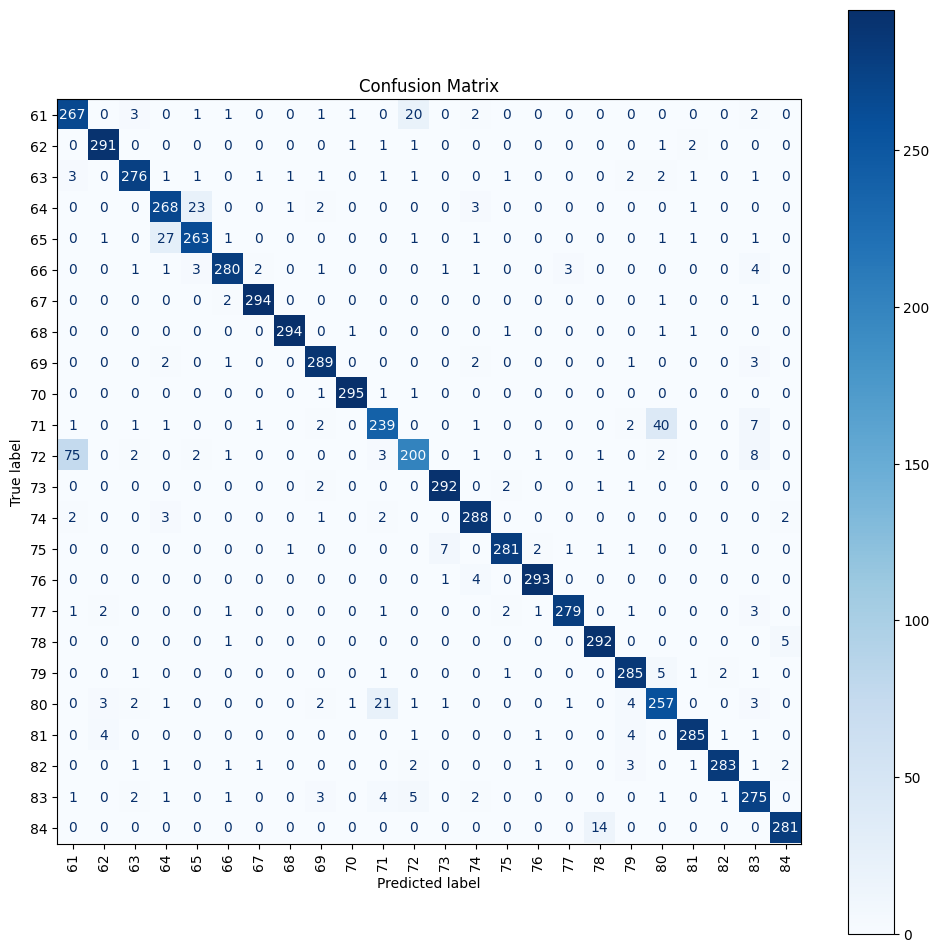


📈 ROC Curve (One-vs-Rest)


KeyError: 25

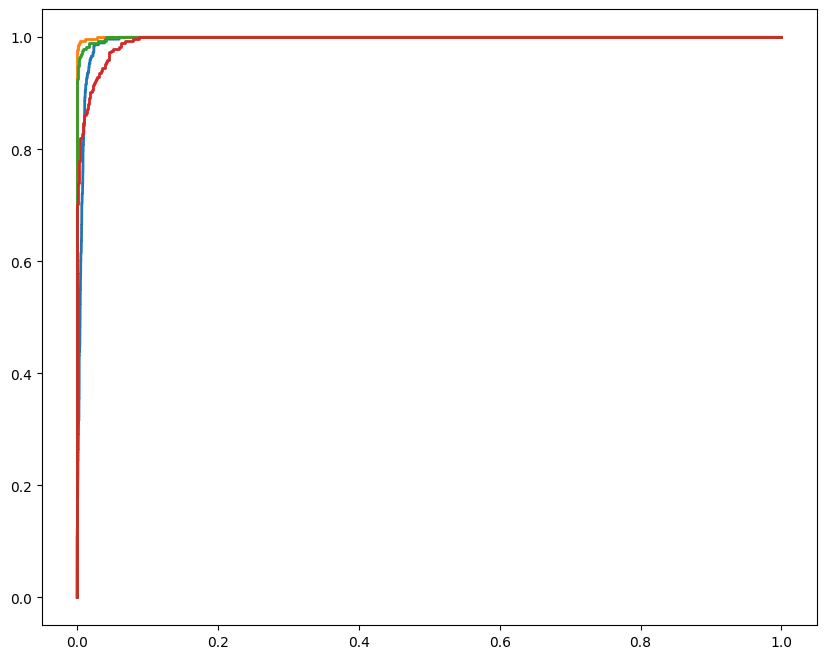

In [15]:
# Thesis Metrics and Visualization for EMNIST ByClass A-Z
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Classification Report
print("\n\U0001F4CB Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Macro & Weighted Scores
print("\n\U0001F522 Macro & Weighted Scores")
for average in ["macro", "weighted"]:
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"\n{average.capitalize()}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Per-Class Scores
print("\n\U0001F4DD Per-Class Metrics")
for i, label in enumerate(class_names):
    precision = precision_score(y_true == i, y_pred == i)
    recall = recall_score(y_true == i, y_pred == i)
    f1 = f1_score(y_true == i, y_pred == i)
    print(f"{label}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve
print("\n\U0001F4C8 ROC Curve (One-vs-Rest)")
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot a few example ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, 10))
for i, c in zip([0, 1, 2, 10, 25], colors):  # change to any class indices
    plt.plot(fpr[i], tpr[i], color=c, lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Example ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
✅ Confusion matrix saved to: confusion_matrix.png


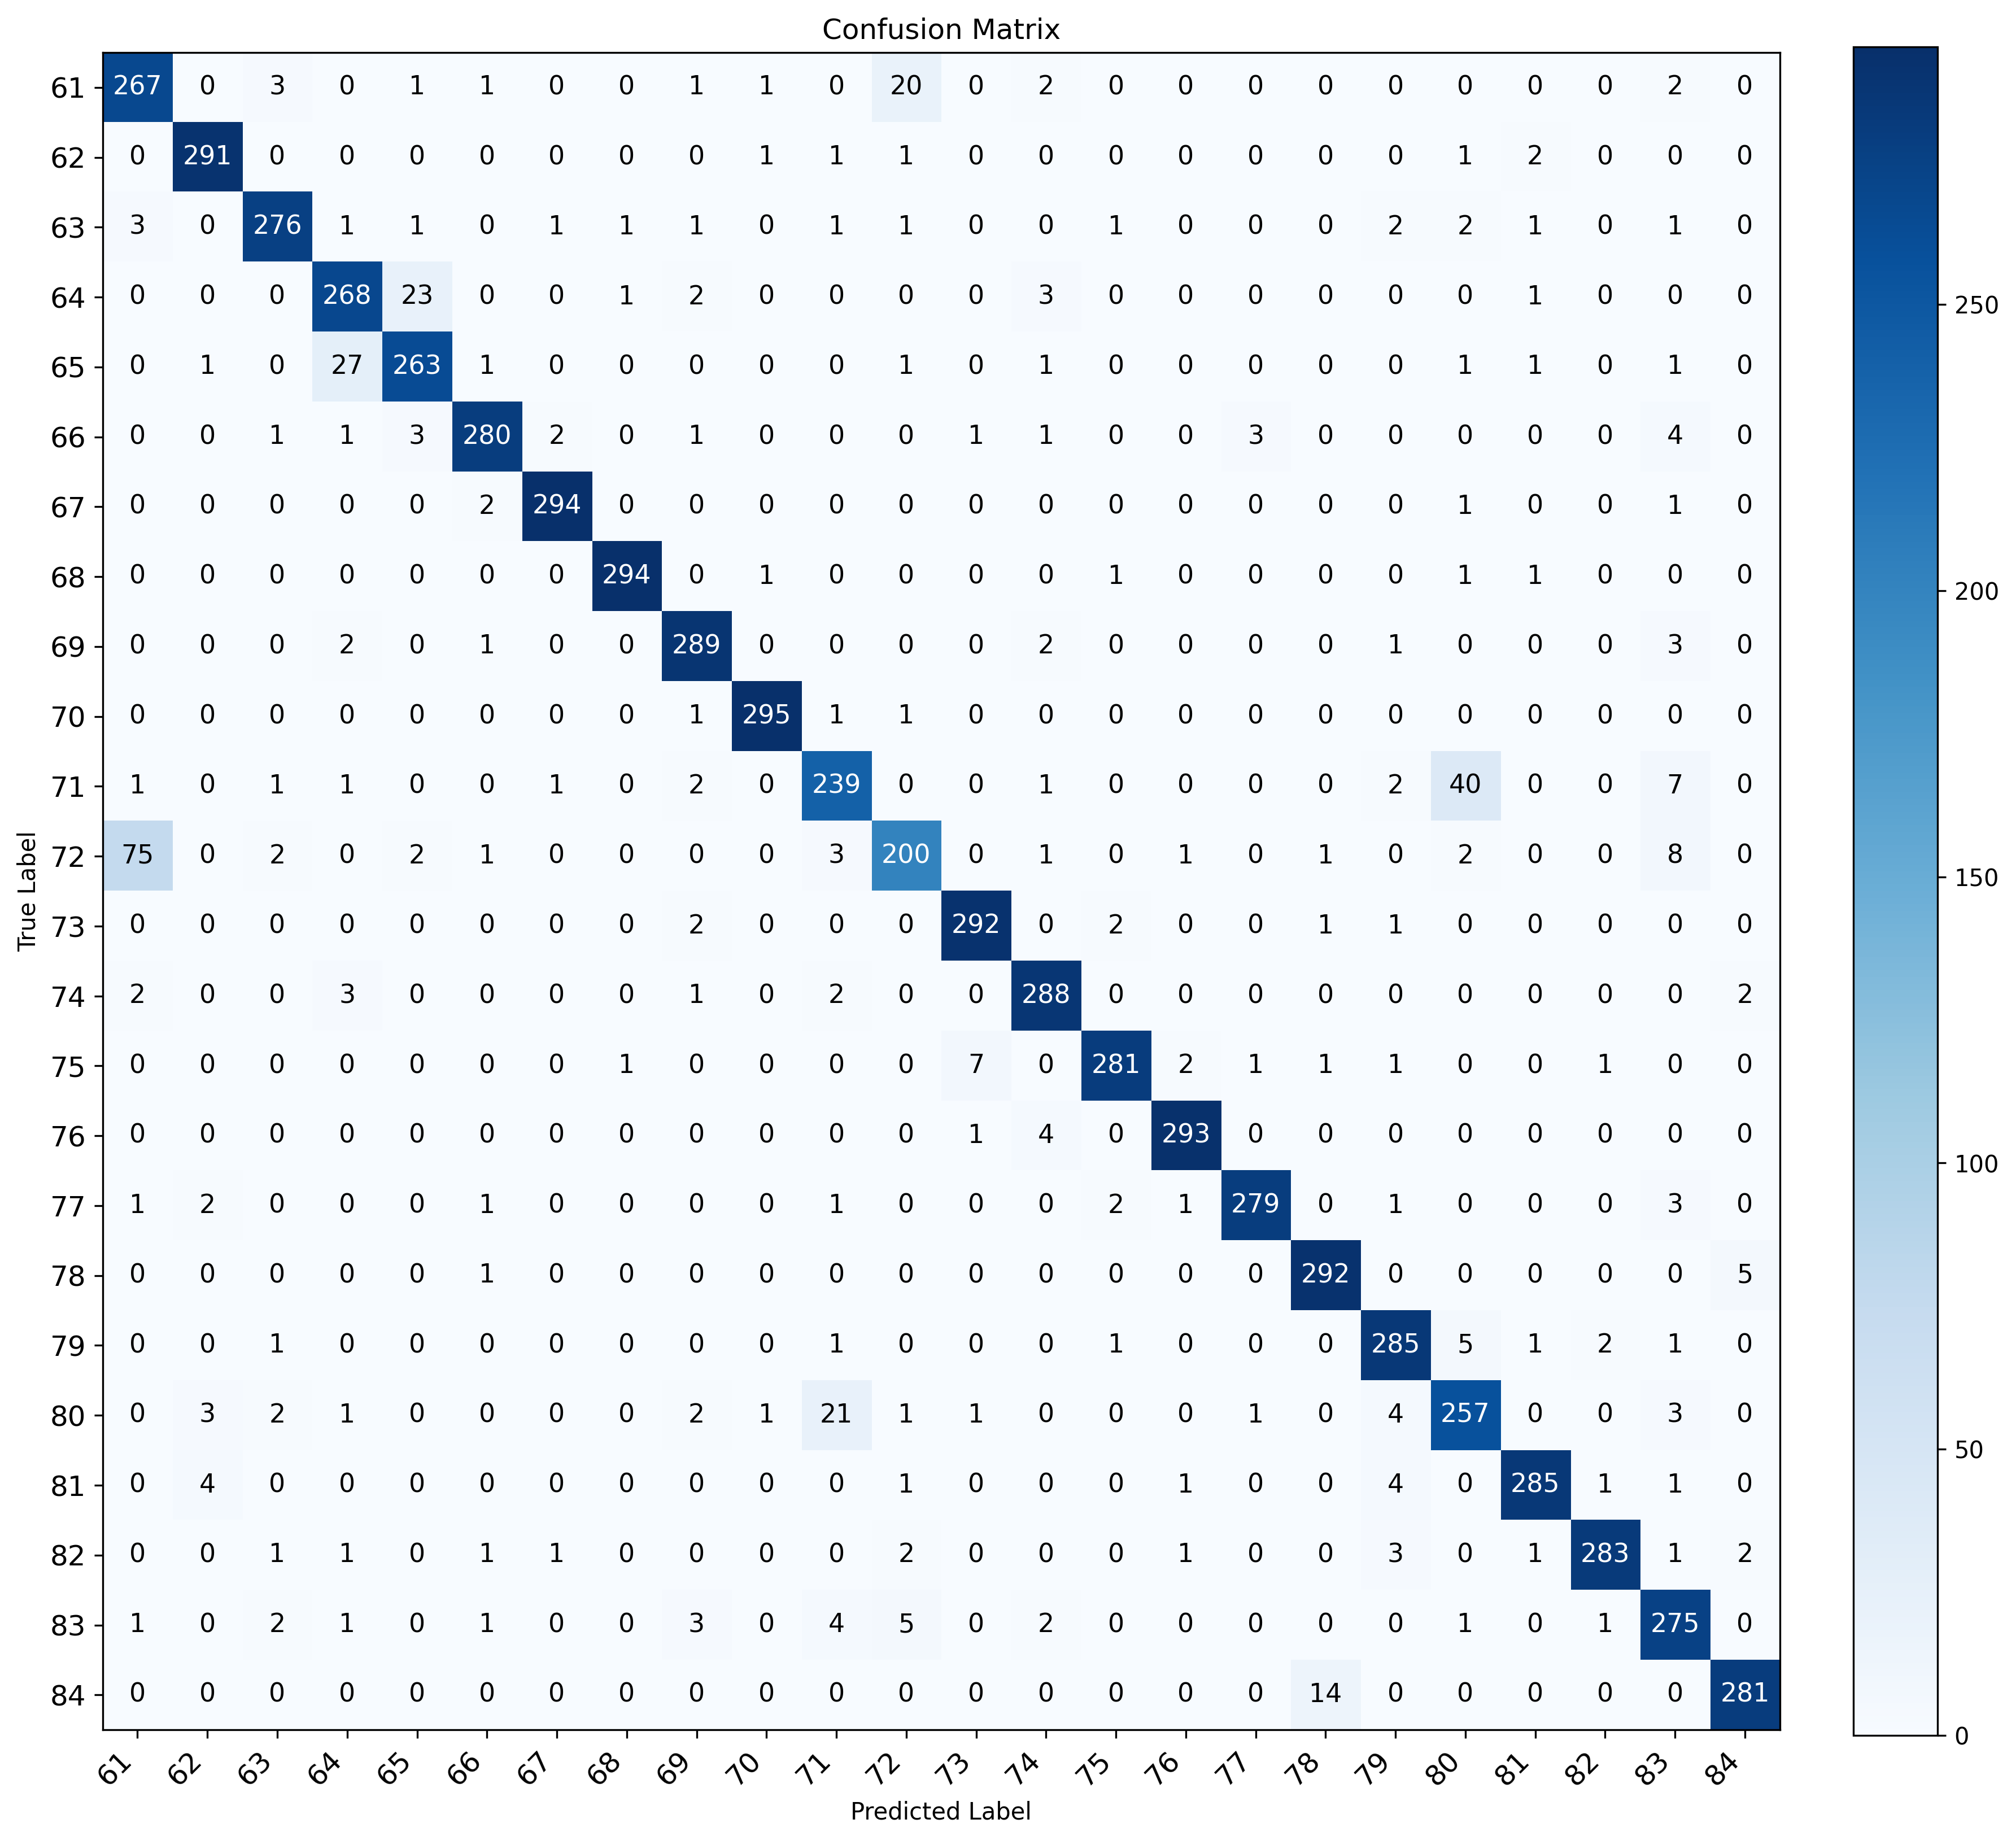

📋 Classification Report:

              precision    recall  f1-score   support

          61     0.7629    0.8960    0.8241       298
          62     0.9668    0.9798    0.9732       297
          63     0.9550    0.9420    0.9485       293
          64     0.8758    0.8993    0.8874       298
          65     0.8976    0.8855    0.8915       297
          66     0.9655    0.9428    0.9540       297
          67     0.9833    0.9866    0.9849       298
          68     0.9899    0.9866    0.9882       298
          69     0.9475    0.9698    0.9585       298
          70     0.9866    0.9899    0.9883       298
          71     0.8723    0.8102    0.8401       295
          72     0.8584    0.6757    0.7561       296
          73     0.9669    0.9799    0.9733       298
          74     0.9443    0.9664    0.9552       298
          75     0.9757    0.9525    0.9640       295
          76     0.9799    0.9832    0.9816       298
          77     0.9824    0.9588    0.9704       291
 

/tmp/ipykernel_35/262129706.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


✅ ROC curve plot saved to: roc_curves.png


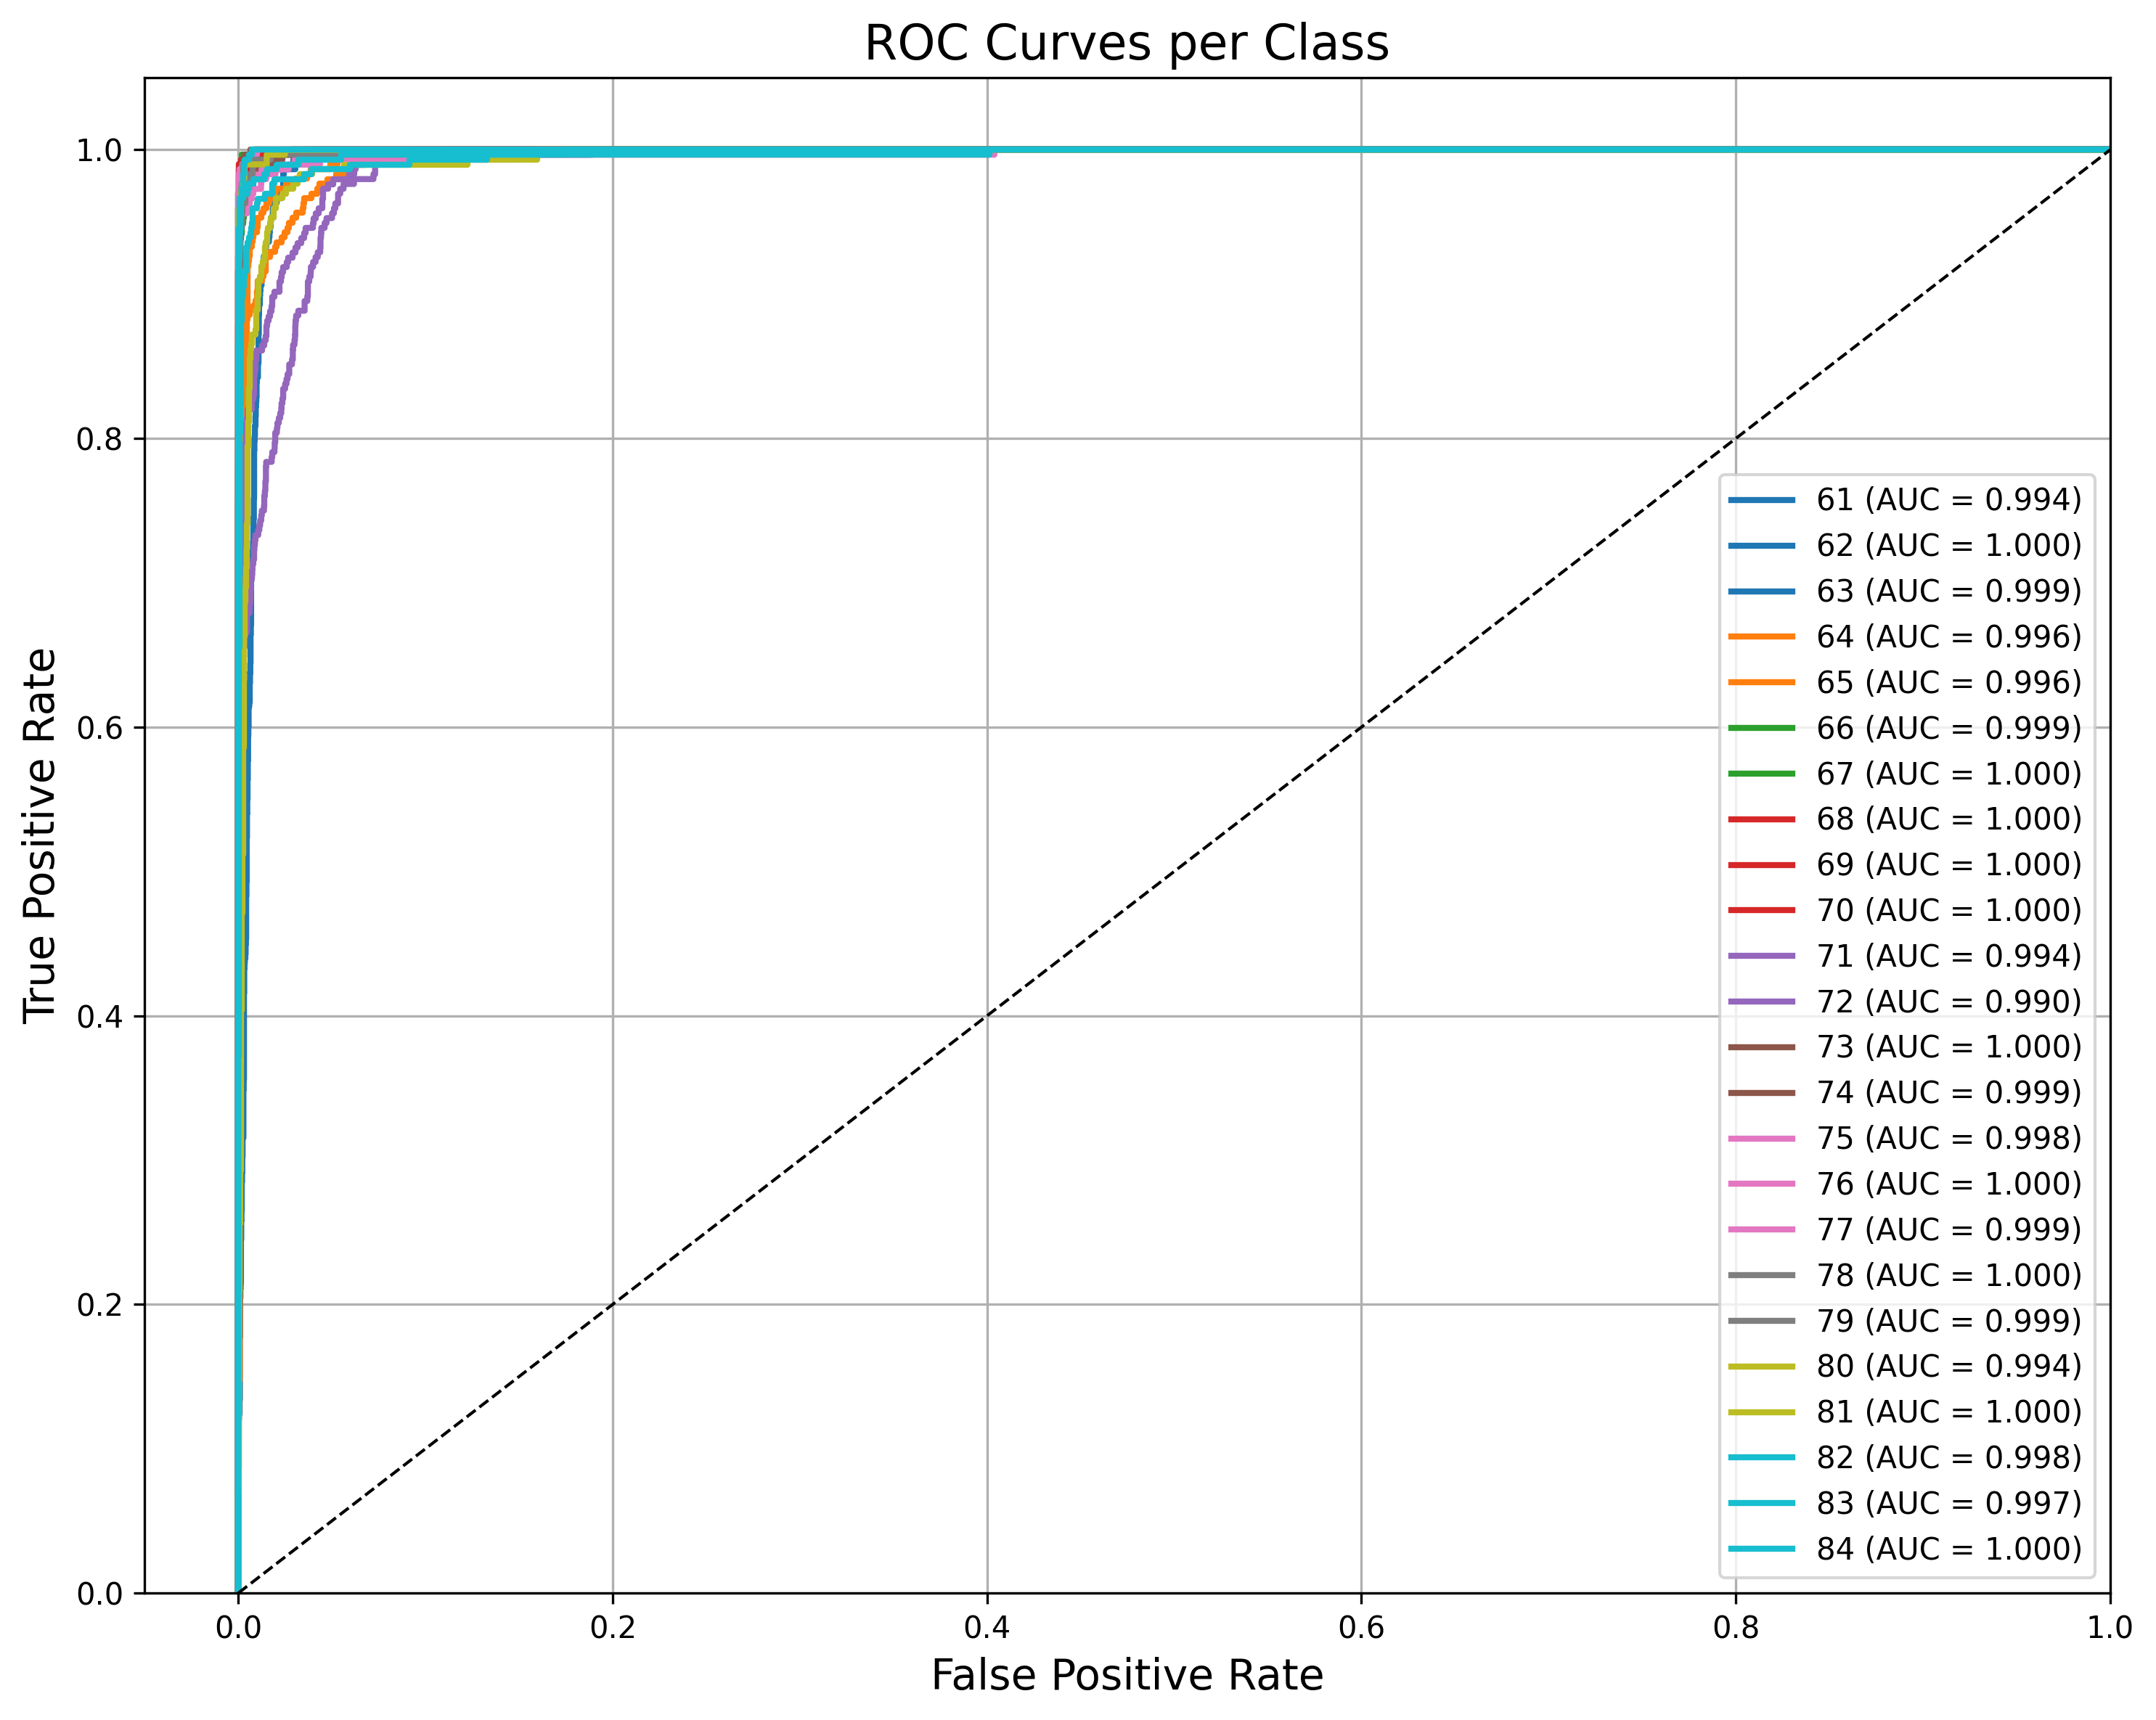

✅ Classification report metrics saved to: metrics.csv


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import pandas as pd
from sklearn.preprocessing import label_binarize

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues',
    dpi=150,       # Higher DPI for better quality
    show_grid=False  # Remove cell lines (default off)
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    if show_grid:
        ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        # Disable grid & ticks for minor
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_probs, class_names, dpi=150):
    """
    Plot ROC curves for each class (one-vs-rest).

    Parameters:
    - y_true: true labels (integer encoded)
    - y_pred_probs: predicted probabilities (num_samples x num_classes)
    - class_names: list of class names
    - dpi: figure dpi for quality
    """
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(10, 8), dpi=dpi)

    # Colors for the curves
    colors = plt.cm.get_cmap('tab10', num_classes)

    for i in range(num_classes):
        if len(np.unique(y_true_bin[:, i])) > 1:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors(i), lw=2,
                     label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
        else:
            # Class not present in true labels, skip ROC curve
            print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves per Class', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_model(
    model, test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path=None,
    export_cm_path=None,
    export_roc_path=None
):
    """
    Generalized evaluation for multi-class classifier with metrics and confusion matrix,
    ROC curve plotting, and export capabilities.

    Parameters:
    - model: keras or sklearn-like model with predict method.
    - test_generator: generator or dataset with .classes and .class_indices attributes.
    - threshold: threshold for ROC-AUC binary decisions (not used here but for reference).
    - plot_cm: bool, whether to plot confusion matrix.
    - normalize_cm: bool, normalize confusion matrix.
    - plot_roc: bool, whether to plot ROC curves.
    - export_metrics_path: str or None, path to save metrics CSV.
    - export_cm_path: str or None, path to save confusion matrix PNG.
    - export_roc_path: str or None, path to save ROC curves PNG.

    Returns:
    - metrics_df: pandas DataFrame with per-class metrics.
    """

    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    num_classes = len(class_names)

    # 1. Confusion matrix plot
    if plot_cm:
        # Setup DPI for export or display
        dpi_val = 300 if export_cm_path else 150
        num_classes = len(class_names)
        cell_scale = 0.5
        fig_width = min(25, max(10, num_classes * cell_scale))
        fig_height = min(25, max(10, num_classes * cell_scale))

        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi_val)

        cm = confusion_matrix(y_true, y_pred)
        if normalize_cm:
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            cm_norm = cm

        im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
        cbar.ax.tick_params(labelsize=10)

        ax.set(
            xticks=np.arange(num_classes),
            yticks=np.arange(num_classes),
            xticklabels=class_names,
            yticklabels=class_names,
            xlabel='Predicted Label',
            ylabel='True Label',
            title="Confusion Matrix"
        )

        tick_font = max(7, 14 - num_classes // 10)
        rotation_angle = 45 if num_classes > 10 else 0
        plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
        plt.setp(ax.get_yticklabels(), fontsize=tick_font)

        # No grid lines as requested
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

        fmt = '.2f' if normalize_cm else 'd'
        thresh = cm_norm.max() / 2.
        annotation_font = max(6, 13 - num_classes // 10)
        for i in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                val = format(cm_norm[i, j], fmt)
                ax.text(j, i, val,
                        ha="center", va="center",
                        fontsize=annotation_font,
                        color="white" if cm_norm[i, j] > thresh else "black")

        plt.tight_layout()

        if export_cm_path:
            fig.savefig(export_cm_path, dpi=dpi_val)
            print(f"✅ Confusion matrix saved to: {export_cm_path}")

        plt.show()

    # 2. Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Macro, Weighted, and Micro Precision, Recall, F1
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

    # 4. ROC Curves
    if plot_roc:
        if y_pred_probs.shape[1] == num_classes:
            dpi_val_roc = 300 if export_roc_path else 150
            plt.figure(figsize=(10, 8), dpi=dpi_val_roc)
            y_true_bin = label_binarize(y_true, classes=range(num_classes))
            colors = plt.cm.get_cmap('tab10', num_classes)
            for i in range(num_classes):
                if len(np.unique(y_true_bin[:, i])) > 1:
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, color=colors(i), lw=2,
                             label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
                else:
                    print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")
            plt.plot([0, 1], [0, 1], 'k--', lw=1)
            plt.xlim([-0.05, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=14)
            plt.ylabel('True Positive Rate', fontsize=14)
            plt.title('ROC Curves per Class', fontsize=16)
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(True)
            plt.tight_layout()
            if export_roc_path:
                plt.savefig(export_roc_path, dpi=dpi_val_roc)
                print(f"✅ ROC curve plot saved to: {export_roc_path}")
            plt.show()
        else:
            print("ROC curve plotting skipped due to mismatch in prediction probabilities dimension.")

    # 5. Export metrics dataframe if path provided
    if export_metrics_path:
        # Prepare metrics DataFrame from classification report
        metrics_df = pd.DataFrame(report).transpose()
        metrics_df.to_csv(export_metrics_path)
        print(f"✅ Classification report metrics saved to: {export_metrics_path}")

    return {
        "classification_report_dict": report,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }


results = evaluate_model(
    model,
    test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path="metrics.csv",     # Optional
    export_cm_path="confusion_matrix.png", # Optional
    export_roc_path="roc_curves.png"       # Optional
)


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (64, 64)
input_shape = (64, 64, 1)
batch_size = 64
epochs = 60
num_classes = 24  # Update if using fewer classes


# Paths after splitting
train_path = "/kaggle/working/banglalekha_compound_split/train"
val_path   = "/kaggle/working/banglalekha_compound_split/val"
test_path  = "/kaggle/working/banglalekha_compound_split/test"

# Augmented training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


Found 33174 images belonging to 24 classes.
Found 7113 images belonging to 24 classes.
Found 7120 images belonging to 24 classes.


In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------

def build_scriptnet_enhanced(input_shape=(64, 64, 1), num_classes=24):
    inputs = Input(shape=input_shape, name='input_layer')

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Block 4 - Deeper features
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Fully connected layers
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNetEnhancedV2')
    return model
print("Model initialized")

Model initialized


In [19]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet_enhanced(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "ScriptNetEnhancedV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,245,912 (20.01 MB)

 Trainable params: 5,240,024 (19.99 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [20]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=12, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_EMNIST_a-z_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=80

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3645 - loss: 2.2697
Epoch 1: val_accuracy improved from -inf to 0.80402, saving model to scriptnet_EMNIST_a-z_best.h5
519/519 ━━━━━━━━━━━━━━━━━━━━ 80s 109ms/step - accuracy: 0.3649 - loss: 2.2681 - val_accuracy: 0.8040 - val_loss: 0.6307 - learning_rate: 0.0010
Epoch 2/80
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8092 - loss: 0.6148
Epoch 2: val_accuracy did not improve from 0.80402
519/519 ━━━━━━━━━━━━━━━━━━━━ 45s 87ms/step - accuracy: 0.8092 - loss: 0.6147 - val_accuracy: 0.7818 - val_loss: 0.7904 - learning_rate: 0.0010
Epoch 3/80
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8557 - loss: 0.4698
Epoch 3: val_accuracy improved from 0.80402 to 0.87516, saving model to scriptnet_EMNIST_a-z_best.h5
519/519 ━━━━━━━━━━━━━━━━━━━━ 45s 87ms/step - accuracy: 0.8557 - loss: 0.4698 - val_accuracy: 0.8752 - val_loss: 0.4237 - learning_rate: 0.0010
Epoch 4/80
519/519 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.873

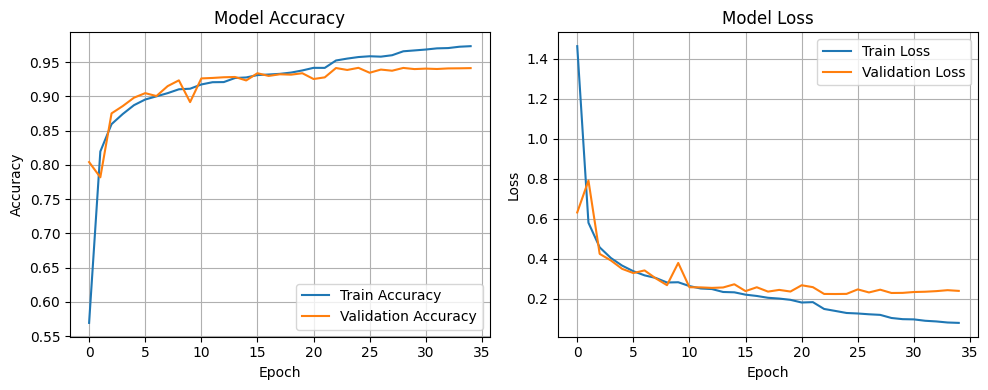

In [21]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step


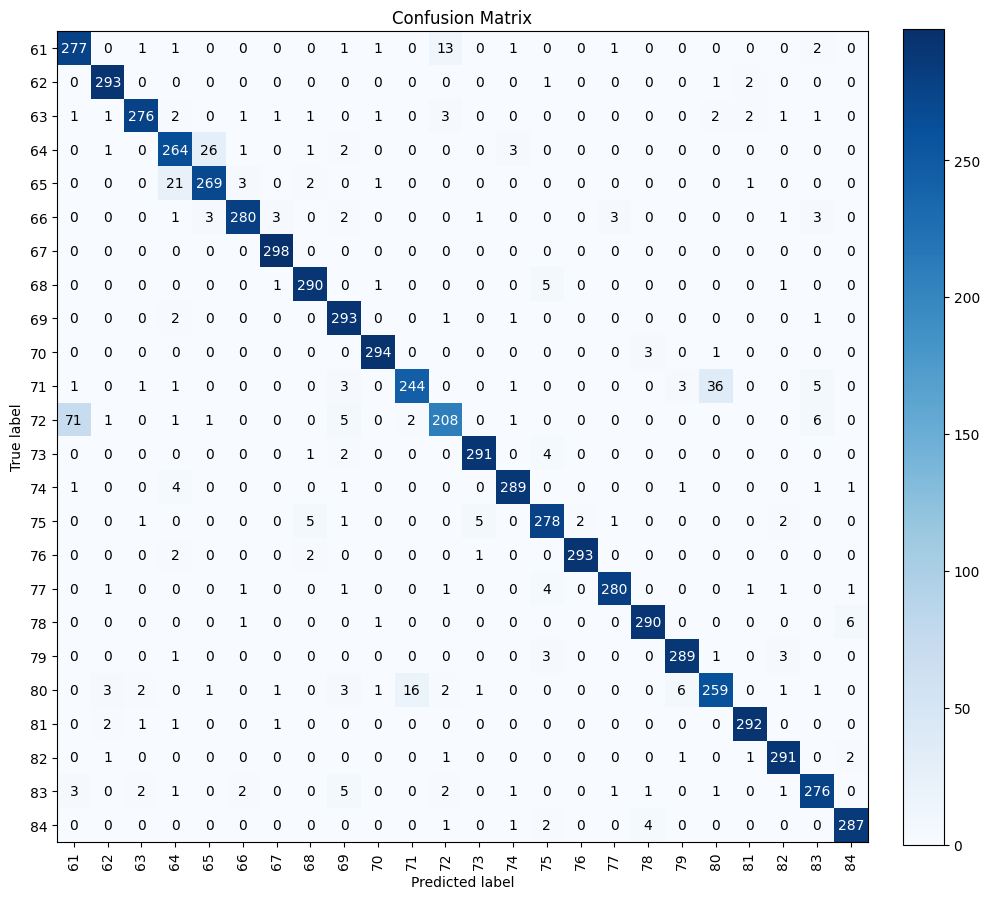

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Create the plot manually to control the layout
fig, ax = plt.subplots(figsize=(10, 10))  # Size based on number of classes
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # ⬅ Match matrix height

# Add labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label',
    title="Confusion Matrix"
)

# Rotate the tick labels and set font sizes
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

# Annotate each cell with its count
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


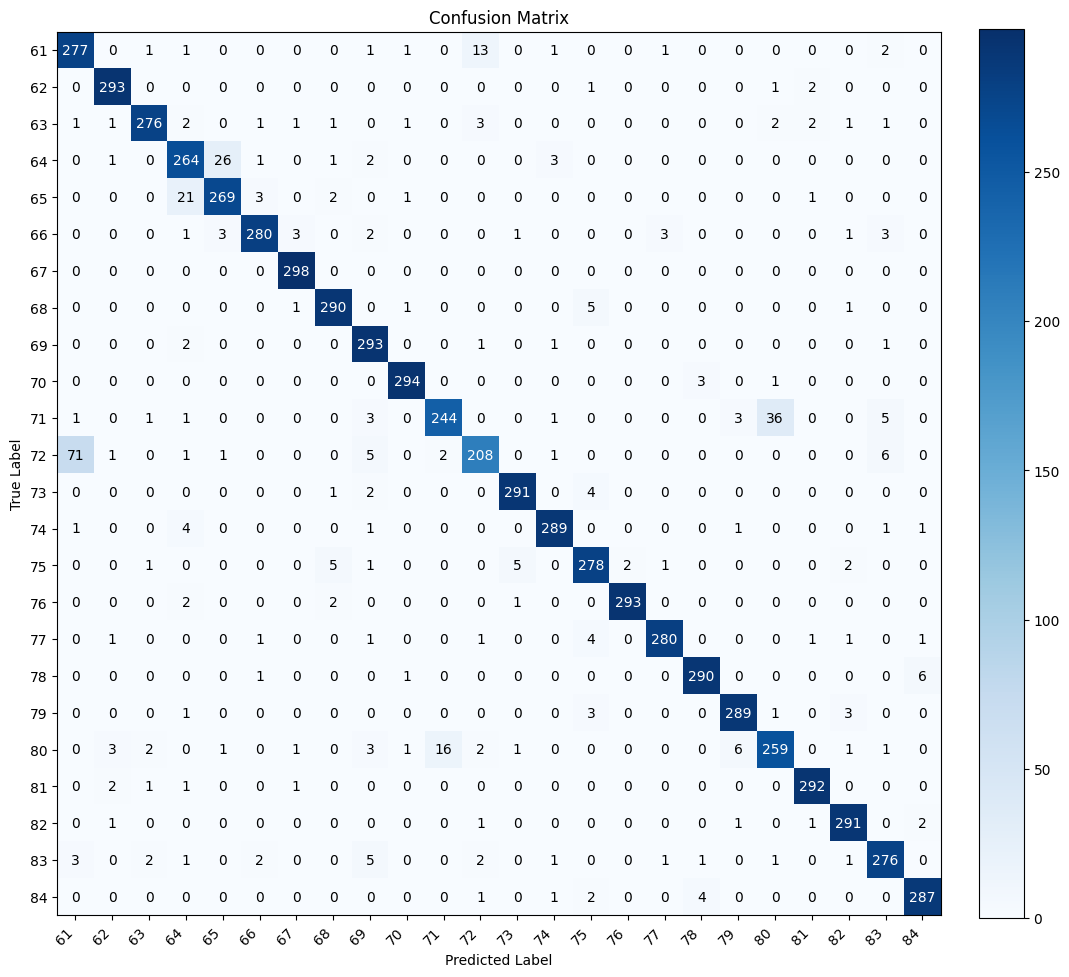

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_general(y_true, y_pred, class_labels, title="Confusion Matrix"):
    num_classes = len(class_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Dynamic figure size based on number of classes
    cell_scale = 0.45  # You can tune this for spacing
    fig_width = min(25, max(8, num_classes * cell_scale))
    fig_height = min(25, max(6, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Display matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Colorbar height matches matrix height
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)

    # Set axis labels and ticks
    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    # Adjust tick labels: auto font size and rotation
    tick_font = max(6, 12 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    # Annotate cells with counts
    fmt = 'd'
    thresh = cm.max() / 2.
    annotation_font = max(5, 12 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Example usage (in your notebook):
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix_general(y_true, y_pred, class_labels)


In [24]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
📋 Classification Report:

              precision    recall  f1-score   support

          61     0.7825    0.9295    0.8497       298
          62     0.9670    0.9865    0.9767       297
          63     0.9718    0.9420    0.9567       293
          64     0.8742    0.8859    0.8800       298
          65     0.8967    0.9057    0.9012       297
          66     0.9689    0.9428    0.9556       297
          67     0.9770    1.0000    0.9884       298
          68     0.9603    0.9732    0.9667       298
          69     0.9185    0.9832    0.9498       298
          70     0.9800    0.9866    0.9833       298
          71     0.9313    0.8271    0.8761       295
          72     0.8966    0.7027    0.7879       296
          73     0.9732    0.9765    0.9749       298
          74     0.9698    0.9698    0.9698       298
          75     0.9360    0.9424    0.9392       295
          76     0.9932    0.9832    0.9882       298
          77 

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(24)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |     298 |       0.9295 |             277.0000 |       0.9887 |             294.6365
    1 |     297 |       0.9865 |             293.0000 |       0.9985 |             296.5647
    2 |     293 |       0.9420 |             276.0000 |       0.9988 |             292.6567
    3 |     298 |       0.8859 |             264.0000 |       0.9944 |             296.3401
    4 |     297 |       0.9057 |             269.0000 |       0.9955 |             295.6506
    5 |     297 |       0.9428 |             280.0000 |       0.9987 |             296.6082
    6 |     298 |       1.0000 |             298.0000 |       0.9990 |             297.6942
    7 |     298 |       0.9732 |             290.0000 |       0.9982 |             297.4758
    8 |     298 |       0.9832 |       

112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

📋 Classification Report:

              precision    recall  f1-score   support

          61     0.7825    0.9295    0.8497       298
          62     0.9670    0.9865    0.9767       297
          63     0.9718    0.9420    0.9567       293
          64     0.8742    0.8859    0.8800       298
          65     0.8967    0.9057    0.9012       297
          66     0.9689    0.9428    0.9556       297
          67     0.9770    1.0000    0.9884       298
          68     0.9603    0.9732    0.9667       298
          69     0.9185    0.9832    0.9498       298
          70     0.9800    0.9866    0.9833       298
          71     0.9313    0.8271    0.8761       295
          72     0.8966    0.7027    0.7879       296
          73     0.9732    0.9765    0.9749       298
          74     0.9698    0.9698    0.9698       298
          75     0.9360    0.9424    0.9392       295
          76     0.9932    0.9832    0.9882       298
          77

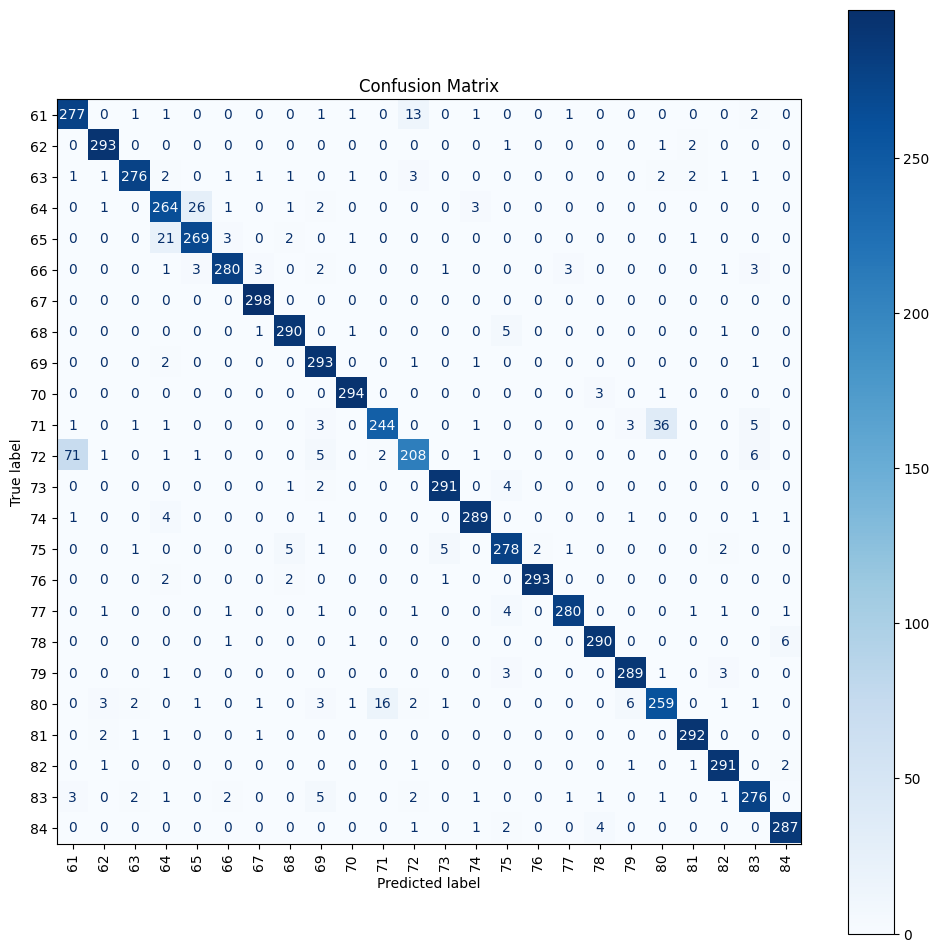


📈 ROC Curve (One-vs-Rest)


KeyError: 25

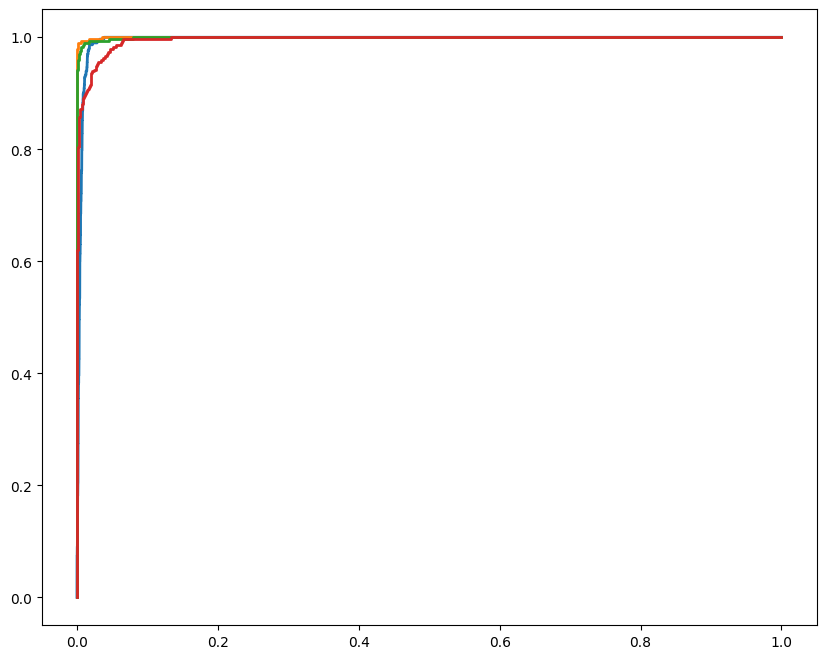

In [26]:
# Thesis Metrics and Visualization for EMNIST ByClass A-Z
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize

# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Classification Report
print("\n\U0001F4CB Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Macro & Weighted Scores
print("\n\U0001F522 Macro & Weighted Scores")
for average in ["macro", "weighted"]:
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    print(f"\n{average.capitalize()}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Per-Class Scores
print("\n\U0001F4DD Per-Class Metrics")
for i, label in enumerate(class_names):
    precision = precision_score(y_true == i, y_pred == i)
    recall = recall_score(y_true == i, y_pred == i)
    f1 = f1_score(y_true == i, y_pred == i)
    print(f"{label}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ROC Curve
print("\n\U0001F4C8 ROC Curve (One-vs-Rest)")
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot a few example ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab20(np.linspace(0, 1, 10))
for i, c in zip([0, 1, 2, 10, 25], colors):  # change to any class indices
    plt.plot(fpr[i], tpr[i], color=c, lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Example ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
✅ Confusion matrix saved to: confusion_matrix.png


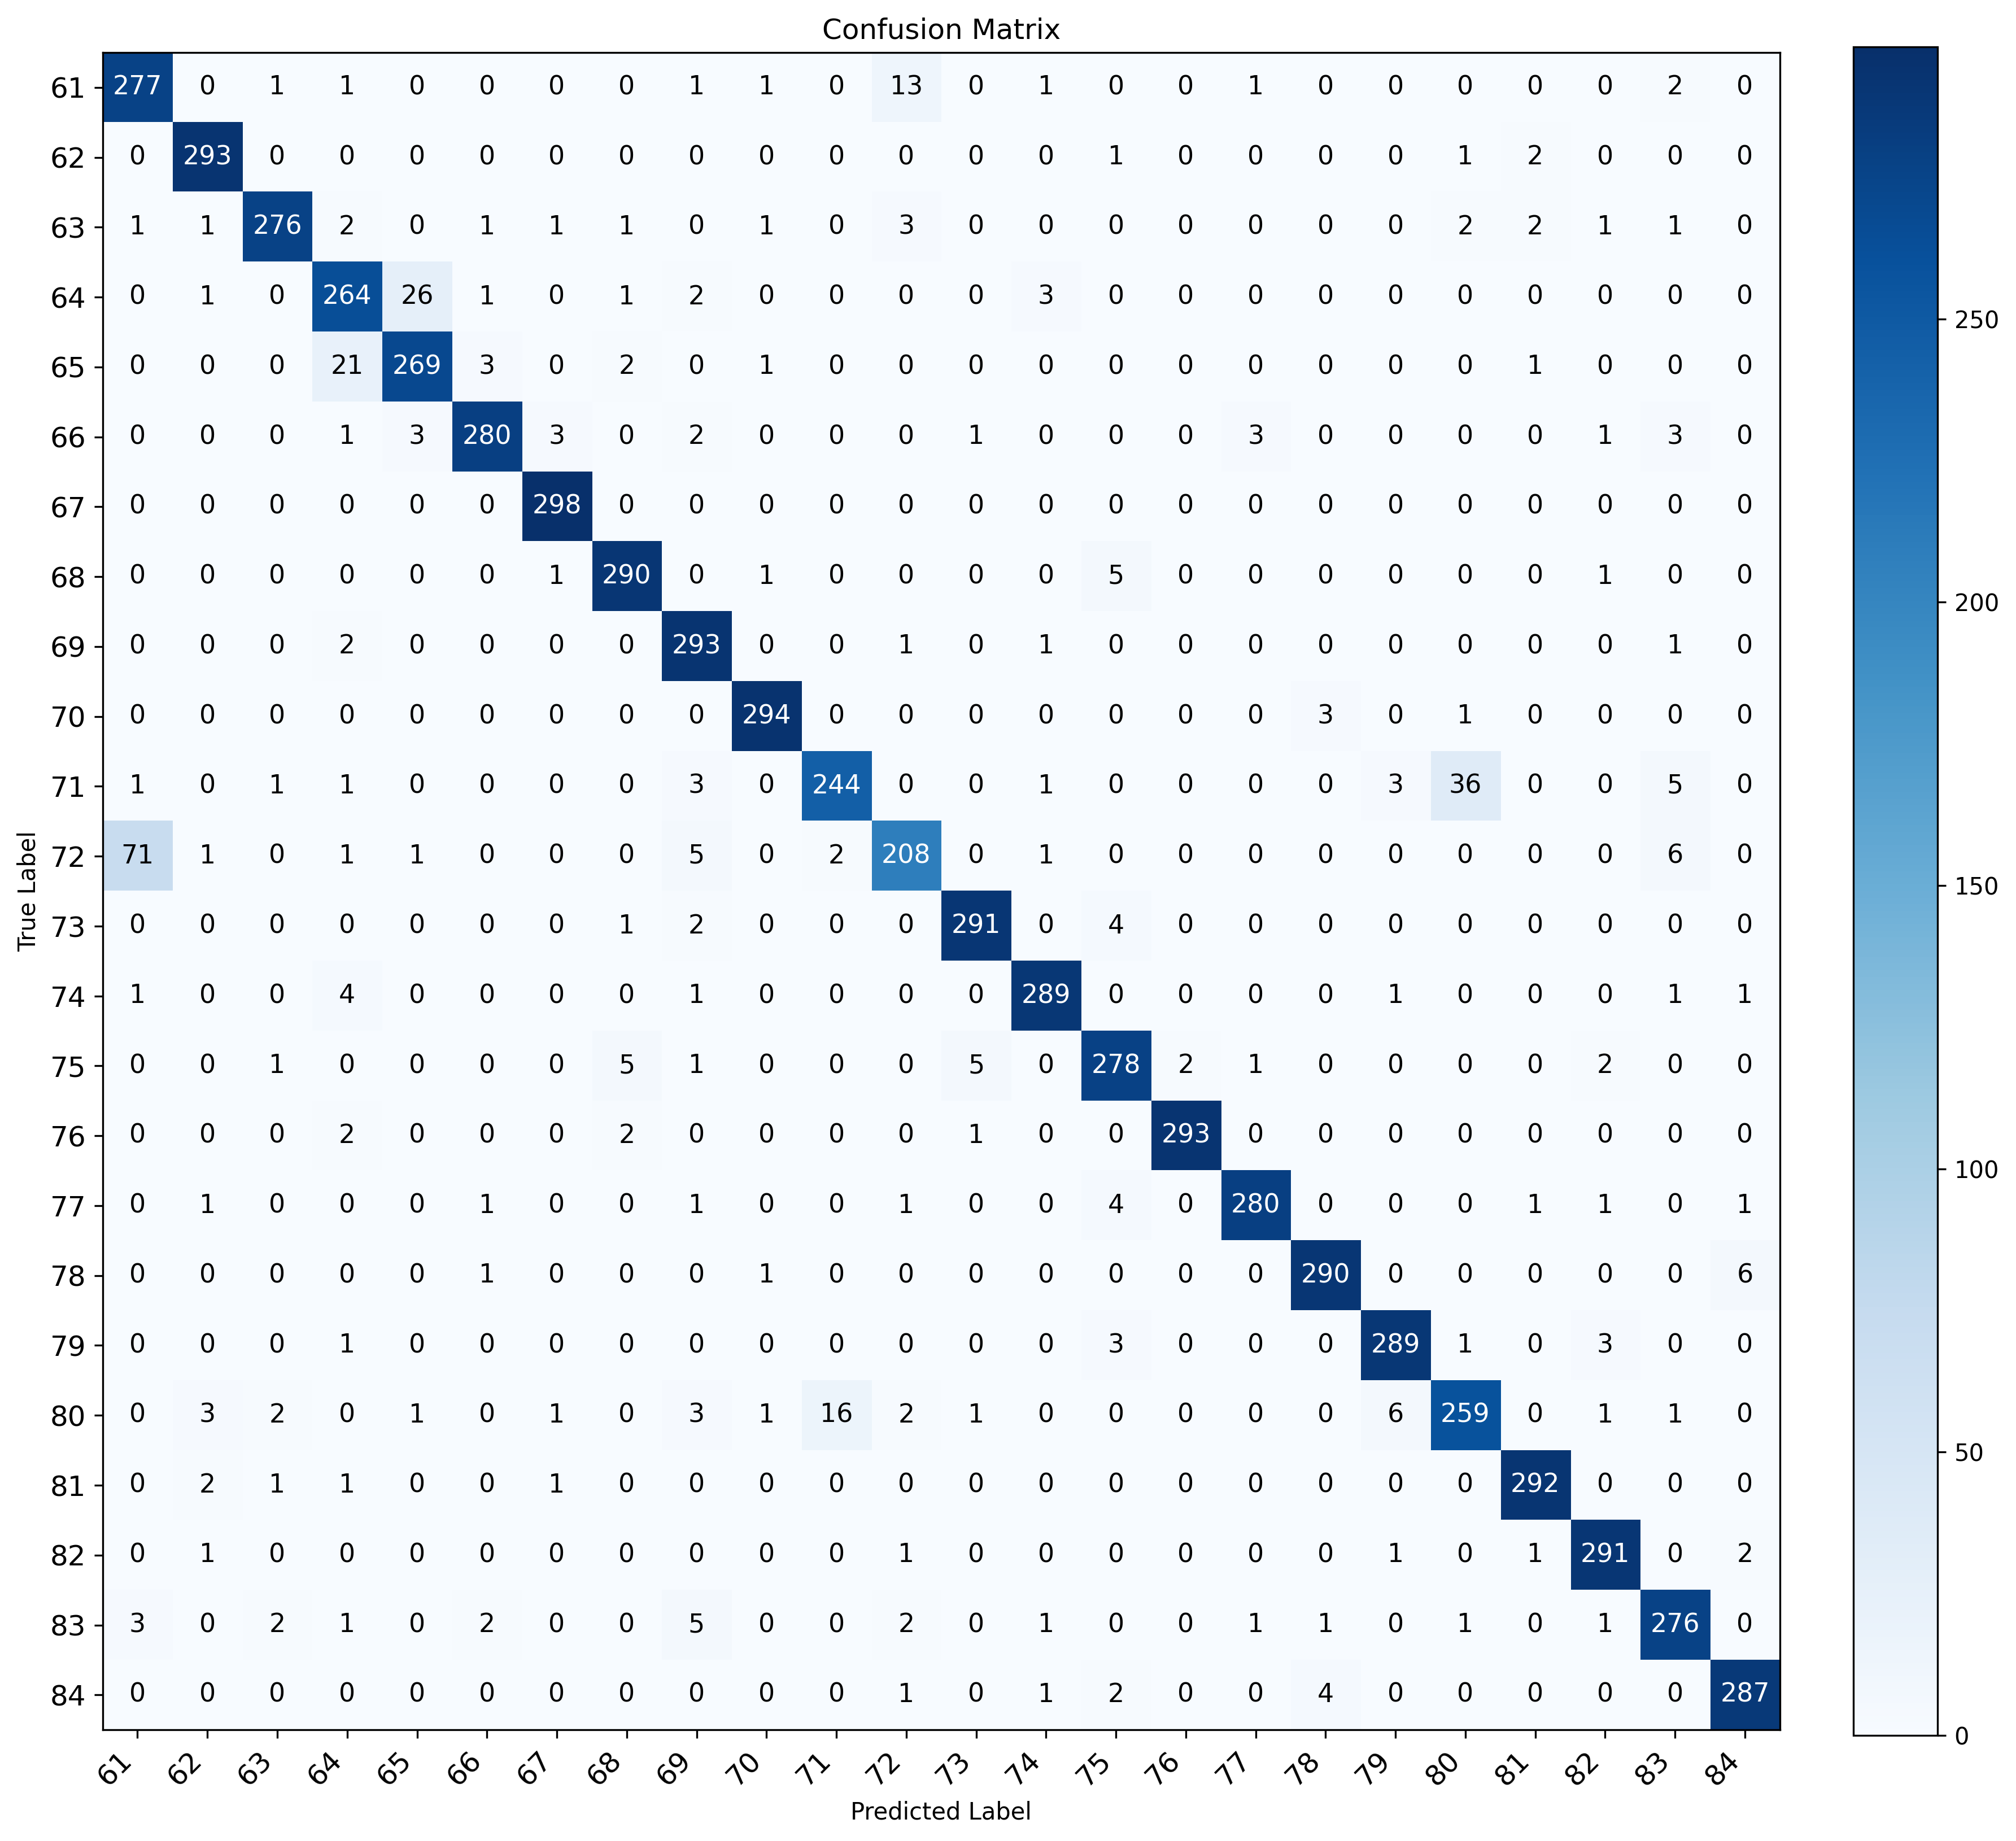

📋 Classification Report:

              precision    recall  f1-score   support

          61     0.7825    0.9295    0.8497       298
          62     0.9670    0.9865    0.9767       297
          63     0.9718    0.9420    0.9567       293
          64     0.8742    0.8859    0.8800       298
          65     0.8967    0.9057    0.9012       297
          66     0.9689    0.9428    0.9556       297
          67     0.9770    1.0000    0.9884       298
          68     0.9603    0.9732    0.9667       298
          69     0.9185    0.9832    0.9498       298
          70     0.9800    0.9866    0.9833       298
          71     0.9313    0.8271    0.8761       295
          72     0.8966    0.7027    0.7879       296
          73     0.9732    0.9765    0.9749       298
          74     0.9698    0.9698    0.9698       298
          75     0.9360    0.9424    0.9392       295
          76     0.9932    0.9832    0.9882       298
          77     0.9790    0.9622    0.9705       291
 

/tmp/ipykernel_35/262129706.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


✅ ROC curve plot saved to: roc_curves.png


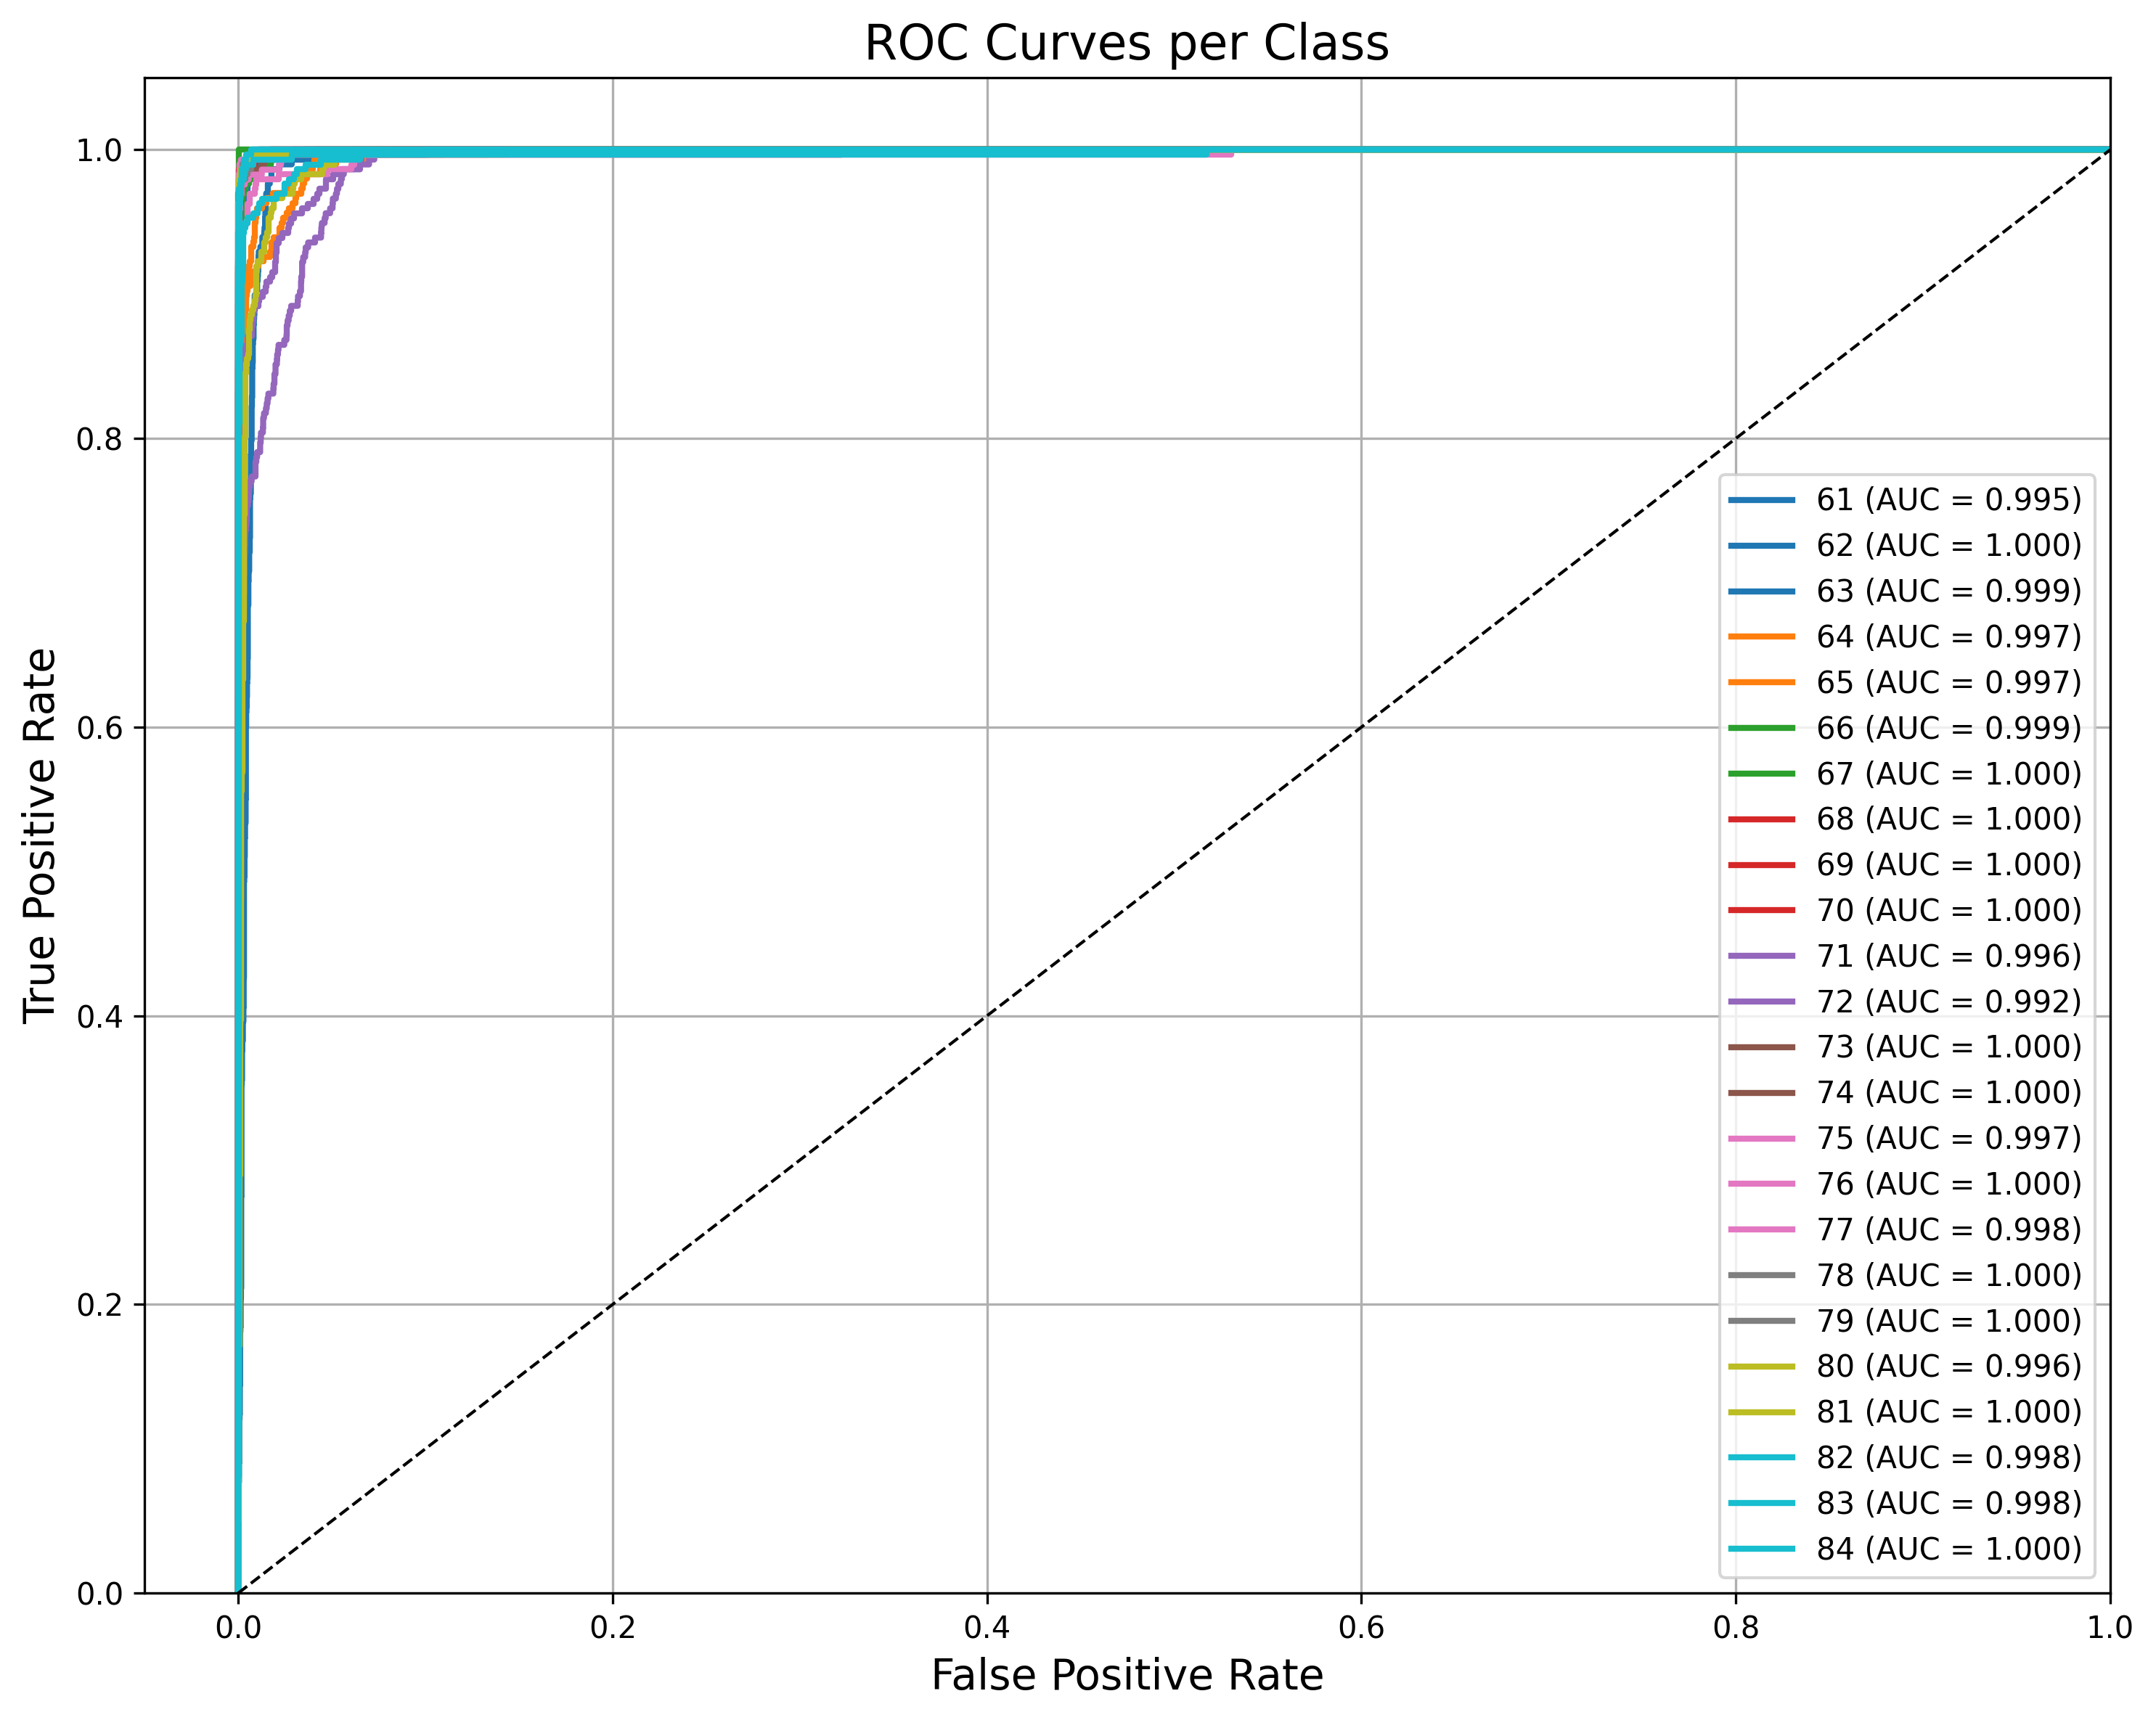

✅ Classification report metrics saved to: metrics.csv


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import pandas as pd
from sklearn.preprocessing import label_binarize

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues',
    dpi=150,       # Higher DPI for better quality
    show_grid=False  # Remove cell lines (default off)
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    if show_grid:
        ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        # Disable grid & ticks for minor
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_probs, class_names, dpi=150):
    """
    Plot ROC curves for each class (one-vs-rest).

    Parameters:
    - y_true: true labels (integer encoded)
    - y_pred_probs: predicted probabilities (num_samples x num_classes)
    - class_names: list of class names
    - dpi: figure dpi for quality
    """
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(10, 8), dpi=dpi)

    # Colors for the curves
    colors = plt.cm.get_cmap('tab10', num_classes)

    for i in range(num_classes):
        if len(np.unique(y_true_bin[:, i])) > 1:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors(i), lw=2,
                     label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
        else:
            # Class not present in true labels, skip ROC curve
            print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves per Class', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_model(
    model, test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path=None,
    export_cm_path=None,
    export_roc_path=None
):
    """
    Generalized evaluation for multi-class classifier with metrics and confusion matrix,
    ROC curve plotting, and export capabilities.

    Parameters:
    - model: keras or sklearn-like model with predict method.
    - test_generator: generator or dataset with .classes and .class_indices attributes.
    - threshold: threshold for ROC-AUC binary decisions (not used here but for reference).
    - plot_cm: bool, whether to plot confusion matrix.
    - normalize_cm: bool, normalize confusion matrix.
    - plot_roc: bool, whether to plot ROC curves.
    - export_metrics_path: str or None, path to save metrics CSV.
    - export_cm_path: str or None, path to save confusion matrix PNG.
    - export_roc_path: str or None, path to save ROC curves PNG.

    Returns:
    - metrics_df: pandas DataFrame with per-class metrics.
    """

    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    num_classes = len(class_names)

    # 1. Confusion matrix plot
    if plot_cm:
        # Setup DPI for export or display
        dpi_val = 300 if export_cm_path else 150
        num_classes = len(class_names)
        cell_scale = 0.5
        fig_width = min(25, max(10, num_classes * cell_scale))
        fig_height = min(25, max(10, num_classes * cell_scale))

        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi_val)

        cm = confusion_matrix(y_true, y_pred)
        if normalize_cm:
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            cm_norm = cm

        im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
        cbar.ax.tick_params(labelsize=10)

        ax.set(
            xticks=np.arange(num_classes),
            yticks=np.arange(num_classes),
            xticklabels=class_names,
            yticklabels=class_names,
            xlabel='Predicted Label',
            ylabel='True Label',
            title="Confusion Matrix"
        )

        tick_font = max(7, 14 - num_classes // 10)
        rotation_angle = 45 if num_classes > 10 else 0
        plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
        plt.setp(ax.get_yticklabels(), fontsize=tick_font)

        # No grid lines as requested
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

        fmt = '.2f' if normalize_cm else 'd'
        thresh = cm_norm.max() / 2.
        annotation_font = max(6, 13 - num_classes // 10)
        for i in range(cm_norm.shape[0]):
            for j in range(cm_norm.shape[1]):
                val = format(cm_norm[i, j], fmt)
                ax.text(j, i, val,
                        ha="center", va="center",
                        fontsize=annotation_font,
                        color="white" if cm_norm[i, j] > thresh else "black")

        plt.tight_layout()

        if export_cm_path:
            fig.savefig(export_cm_path, dpi=dpi_val)
            print(f"✅ Confusion matrix saved to: {export_cm_path}")

        plt.show()

    # 2. Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Macro, Weighted, and Micro Precision, Recall, F1
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

    # 4. ROC Curves
    if plot_roc:
        if y_pred_probs.shape[1] == num_classes:
            dpi_val_roc = 300 if export_roc_path else 150
            plt.figure(figsize=(10, 8), dpi=dpi_val_roc)
            y_true_bin = label_binarize(y_true, classes=range(num_classes))
            colors = plt.cm.get_cmap('tab10', num_classes)
            for i in range(num_classes):
                if len(np.unique(y_true_bin[:, i])) > 1:
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, color=colors(i), lw=2,
                             label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
                else:
                    print(f"Skipping ROC curve for class '{class_names[i]}' due to lack of positive samples.")
            plt.plot([0, 1], [0, 1], 'k--', lw=1)
            plt.xlim([-0.05, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=14)
            plt.ylabel('True Positive Rate', fontsize=14)
            plt.title('ROC Curves per Class', fontsize=16)
            plt.legend(loc="lower right", fontsize=10)
            plt.grid(True)
            plt.tight_layout()
            if export_roc_path:
                plt.savefig(export_roc_path, dpi=dpi_val_roc)
                print(f"✅ ROC curve plot saved to: {export_roc_path}")
            plt.show()
        else:
            print("ROC curve plotting skipped due to mismatch in prediction probabilities dimension.")

    # 5. Export metrics dataframe if path provided
    if export_metrics_path:
        # Prepare metrics DataFrame from classification report
        metrics_df = pd.DataFrame(report).transpose()
        metrics_df.to_csv(export_metrics_path)
        print(f"✅ Classification report metrics saved to: {export_metrics_path}")

    return {
        "classification_report_dict": report,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }


results = evaluate_model(
    model,
    test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path="metrics.csv",     # Optional
    export_cm_path="confusion_matrix.png", # Optional
    export_roc_path="roc_curves.png"       # Optional
)
